# Product's price prediction by nutrition values

In this project we wanted to find the cornection between nutrition values of products and their price. we want to emphasize the that we were awered to the fact that there are other causes to a certain products' price, such as tax, where the product was produced (if it has been imported), etcetera.

Thus, we worked on the project while knowing that there might not be a full connection between the nutrition values and the price of a product, but these are the aspects we chose to focus in our project.

We started by doing web-scraping from the website of the grocery network 'Shufersal'. https://www.shufersal.co.il/online/he/A

The goal is to create a model that accept nutrition values of a product and predicts it's estimate price.

## Table of Contents:
####  1. Getting to know the data, train test split, initial data cleanse
####  2. Creating a new data set
####  3. Analyzing and visualizing the first data set
####  4. Choosing a metric method and checking habits of dummy-model
####  5. Sampling models (and checking with cross validation):
     -A. linear regression
     -B. desicions tree regressor 
     -C. random forest regressor
####  6. comparing models scores and choosing the final model
####  7. conclusion

## 1. Getting to know the data, train test split, initial data cleanse:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as MSE

plt.style.use('seaborn')

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False)
df.head()

,Product_Name,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,Gilded_apple,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,lemon,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,Orange_in_the_juice_network,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,Avocado,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, Product_Name to Chlorophyll
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [4]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)
prod = train_set.copy()

In [5]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
prod= prod.set_index('Product_Name')

In [6]:
#in order to turn all the objects we have to numeric - float or int
for col in prod.columns:  
    prod[col] = pd.to_numeric(prod[col], errors='coerce')
prod = prod.fillna(0)
sts_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (prod != 0).any(axis=0)]
prod.info() #in order to see that we scceeded and to have a look at the columns

<class 'pandas.core.frame.DataFrame'>
Index: 7668 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 97 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7668 non-null   float64
 1   Vitamin_B1                           7668 non-null   float64
 2   Vitamin_B6                           7668 non-null   float64
 3   Dietary_fiber                        7668 non-null   float64
 4   Folic_acid                           7668 non-null   float64
 5   energy                               7668 non-null   float64
 6   Proteins                             7668 non-null   float64
 7   Carbohydrates                        7668 non-null   float64
 8   Fats                                 7668 non-null   float64
 9   sodium                               7668 non-null   float64
 10  Vitamin_B3                           7668

### After a brief look at the cloumns we have, we pointed out a couple of things nedded to be done:
##### get rid of the unwanted units we have:
we want all the get rid of all the products that are not measured by 100_g or 1_kg (and delete the rows of these units).
afterwards, we need to unite the 100_g and 1_kg units (by deviding 1_kg by 10 we'll get the price for 100_g)
#### we'll check which columns left, and with them:
##### unite the columns:
- DHA_fatty_acid and DHA 
- Vitamin_A and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3 (they are reffering to the same thing: https://en.wikipedia.org/wiki/Niacin)
- DHA and EPA with DHA_+_EPA (?)

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [7]:
#first, we'll find the products without the wanted price units 
unwanted_units = prod[(prod['100_g']==0) & (prod['1_kg']==0)].index
print(unwanted_units)
#moreover, we'll check if there are any products with more than one wanted price units 
print(prod[(prod['100_g']!=0) & (prod['1_kg']!=0)].index)
#we'll notice that there are 807 products without the wanted price units and remove them
prod = prod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
prod['1_kg'] = prod['1_kg']/10
prod['price_per_100g'] = prod['1_kg'] + prod['100_g']
prod = prod.drop(['100_g' ,'1_kg'], axis=1)

Index(['Milk_in_a_3%_fat_carton', '5%_Organic_White_Wine_Vinegar',
       'Grape_seed_oil', 'Alpero_Almond_Coconut_Drink', 'Ice_snacks',
       '22%_gluten-free_coconut_cream', 'Thai_sauce_Pad_Thai',
       'Solgar_Super_Gala_300', 'Sweet_chili_sauce', 'Organic_coconut_oil',
       ...
       'Wholemeal_bun_case', 'Soy_drink_for_LS_Alpro',
       'Coffee-flavored_soy_drink', 'Alpro_Chocolate_Soy_Drink', 'Magnox_520',
       'Coconut_cream_20-22%', 'Sweet_and_sour_sauce',
       'Organic_apple_cider_vinegar_5%', 'Donuts_cocoa_cream_+_candies',
       'Natural_apple_juice'],
      dtype='object', name='Product_Name', length=807)
Index([], dtype='object', name='Product_Name')


In [8]:
#in order to reduce background noise, we decided to drop the columns in which there are less than 10 products with this feature
prod = prod.reset_index()
arr = np.array([])
col_droped = np.array([])
for col in prod.columns:
    if prod[col].astype(bool).sum(axis=0)<20: #all the features that less than precent of the products have
        arr = np.append(arr, prod[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col)
print(col_droped)
arr = set(arr) #all number of rows without duplicates
for i in arr:
    prod = prod.drop(i)
prod = prod.drop(col_droped, axis=1)
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero
prod = prod.set_index(['Product_Name'])

['Monounsaturated_fat' 'Polyunsaturated_fat' 'Reduced_sodium' 'Lactose'
 'Vitamin_D_Calciprolol' 'caffeine' 'Fat_without_trans' 'Pantothenic_acid'
 'Of_which_unsaturated_fat' '6_omega_fatty_acids'
 'From_sugars_to_organic_acids' 'wetness' 'ash' 'Salt' 'Lycopene'
 'Soluble_fiber' 'Oleic_fatty_acids' 'starch' 'Lutein' 'Chloride'
 'AA_fatty_acid' 'Vitamin_B3_Nicotinamide_Equilibrium' 'K_Potassium'
 'humidity' 'chromium' 'Molybdenum']


In [9]:
#all_dropped_collumns = all_dropped_collumns+sts_dropped_collumns
all_dropped_collumns

Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Trans_fat', 'Acetic_acid',
       'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA', 'Chlorophyll'],
      dtype='object')

noticed that DHA, EPA and DHA_+_EPA collumns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- Vitamin_A and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- DHA and EPA with DHA_+_EPA (?)~~

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to scale the data in order to avoid any problems that might come with nutrition values that are measured by different units. We wanted to scale only the products and not the prices, so we splitted the prices from the nutrition values and then did the scaling. But before that we created another train and test set based on how many products has values in each column, beacuse logicly, the nutrition values we have more can help us predict the price to a wider range of products.

In [10]:
products = prod.drop("price_per_100g", axis=1)
prices = prod["price_per_100g"].copy()

## 2. creating a new data set, scaling:

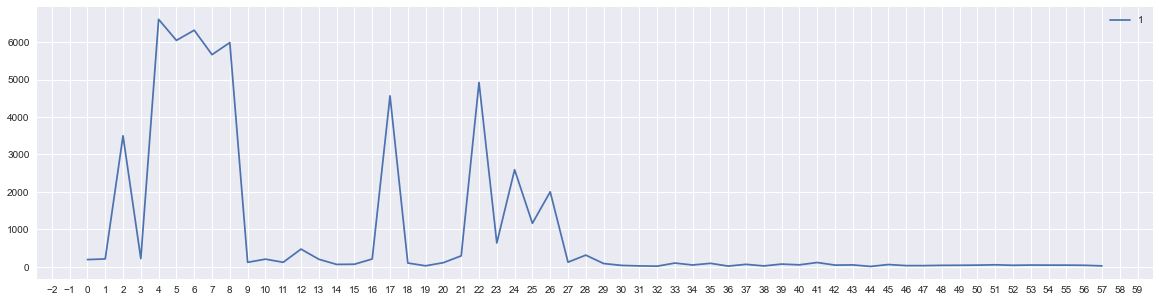

In [11]:
df_num = []
df_name = []
for col in products.columns:
    df_num.append(int(products[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Set a tick on each integer multiple of a base within the view interval.
plta.gcf().set_size_inches(20, 5)
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 26, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns. (the reason we decided not to take specific columns is in order to prevent doing over fitting)

In the end, when we tried to run the models we decided what kind of filltering is the most worthy, and which features are better for predictions (what feature selection we should do)

In [12]:
products2 = products.iloc[:,2:26] 
prices2 = prices.copy()
products2

,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,potassium,Vitamin_C,...,Magnesium,Carbohydrate_sugars,Vitamin_A,Dietary_fiber.1,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.00,89.00,0.80,9.20,6.30,17.5,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,3.30,0.00,0.00,0.0
Pasta_Perfecto_Casserole,1.60,0.00,160.00,0.00,0.00,0.00,0.0,0.0,0,0.0,...,0,1.4,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Whole_champignon_mushrooms,2.20,0.00,18.00,2.10,0.90,0.00,240.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Light_bread_from_whole_spelled,2.45,0.00,38.88,3.07,8.46,0.39,86.9,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.12,0.00,0.00,0.0
Baby_bite_flavored_vegetables,0.00,0.00,8.00,0.00,2.00,0.00,6.0,0.0,0,0.0,...,0,0.3,0.0,0.0,0.0,0.0,0.10,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,0.00,335.00,6.30,76.00,0.00,0.0,0.0,0,0.0,...,0,45.0,0.0,0.0,0.0,0.0,0.00,0.00,11.25,0.0
Slim_Delis_Multi-Grain_Milk,1.60,7.22,59.00,0.80,7.40,2.60,36.4,0.7,0,0.0,...,0,4.4,34.5,0.0,0.0,0.0,1.40,0.00,8.75,0.0
Chocolate_with_popsicles,0.00,0.00,516.00,8.10,58.00,27.00,117.0,0.0,0,0.0,...,0,57.0,0.0,0.0,0.0,0.0,16.50,0.00,14.25,0.0


## 3.Analyzing and visualizing the first data set:

In [13]:
products

,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,...,Nucleotides,Linoleic_fatty_acid,selenium,copper,Taurine,Choline,Inositol,Alpha_linolenic_acid,chlorine,Carnitine
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.000,0.0,0.00,0.00,89.00,0.80,9.20,6.30,17.5,0.0,...,0,0,0,0,0,0,0,0,0,0
Pasta_Perfecto_Casserole,0.000,0.0,1.60,0.00,160.00,0.00,0.00,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Whole_champignon_mushrooms,0.000,0.0,2.20,0.00,18.00,2.10,0.90,0.00,240.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Light_bread_from_whole_spelled,0.000,0.0,2.45,0.00,38.88,3.07,8.46,0.39,86.9,0.0,...,0,0,0,0,0,0,0,0,0,0
Baby_bite_flavored_vegetables,0.000,0.0,0.00,0.00,8.00,0.00,2.00,0.00,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.000,0.0,0.00,0.00,335.00,6.30,76.00,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Slim_Delis_Multi-Grain_Milk,0.055,0.1,1.60,7.22,59.00,0.80,7.40,2.60,36.4,0.7,...,0,0,0,0,0,0,0,0,0,0
Chocolate_with_popsicles,0.000,0.0,0.00,0.00,516.00,8.10,58.00,27.00,117.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### uniting the desired columns:

In [14]:
def merge_two_columns(col1, col2, dataframe, index_col):
    if col1 in dataframe.columns and col2 in dataframe.columns:
        dataframe = dataframe.reset_index()
        row = 0
        for prod in dataframe[col1]:
            if (prod==0):
                if (dataframe.at[row , col2]!=0):
                    dataframe.at[row, col1] =  dataframe.at[row ,col2]  
            row = row+1
        dataframe = dataframe.drop([col2], axis = 1)
        dataframe = dataframe.set_index(index_col, drop=True)
        return dataframe
    else:
        return dataframe

In [15]:
products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', products, 'Product_Name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'Product_Name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'Product_Name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'Product_Name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Nicotinamide', products, 'Product_Name')
products = merge_two_columns('sodium', 'chloride', products, 'Product_Name')

### checking the correlations:

###### checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamoin is because they are often appears together in the same types of food. 

Hence, we'll try to find correlation between the different types of vitamin B, with the goal to unite them all under one column - Vitamin B group.

<AxesSubplot:>

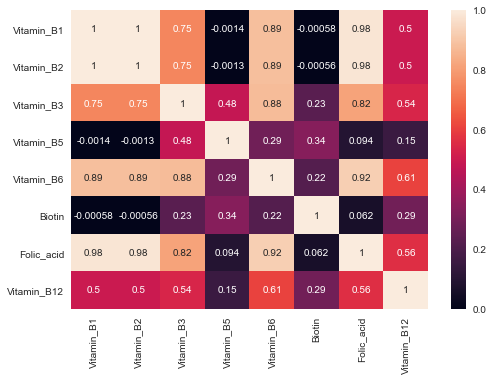

In [16]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = products.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the graph we're concluding that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6 or Vitamin_B9 (Folic_acid). 

We chosed them by the number of correlations that are about>=0.8 (we didn't considered Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of the columns it will be by these criteria:
- the one with the most higher correlations
- the one with the least lower correlations
- the one with the biggest correlation with column we want to predict - price_per_100g

In [17]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B6', 'Folic_acid']
for rep in might_be_rep:
    column_1 = prices
    column_2 = products[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  4
Vitamin_B1 : number of correlations that are below or equal 0.2:  2
correlation between price_per_100g and  Vitamin_B1 :  0.01789411147893502
Vitamin_B6 : number of correlations that are greater than 0.8:  5
Vitamin_B6 : number of correlations that are below or equal 0.2:  0
correlation between price_per_100g and  Vitamin_B6 :  0.027219292407152665
Folic_acid : number of correlations that are greater than 0.8:  5
Folic_acid : number of correlations that are below or equal 0.2:  2
correlation between price_per_100g and  Folic_acid :  0.021029044768790417


By the two first criteria we have putted first, it seems that the columns we should take as a representetive for the Vitamin B group is the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 4), and it has the smallest number of correlations that are below or equal 0.2 (which is 1). It has, as well, the biggest correlation with price_per_100g.

we tried as well a different approach - instead of choosing one column to be the representetive of all the group, we tried to merge between the difeerent Vitamin Bs. we gave more significance to Vitamin_B6 and the one's that were designated to be the representetives by this order: first Vitamin_B6, then Vitamin_B9 (Folic_acid) (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well), After Vitamin_B1, the last of the might_be_rep. Then there was be Vitamin_B12 ,who has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal 0.2. And last but not least were Vitamin_B5, Biotin and Vitamin_B3 because we can see from the graph that Vitamin_B5 has the best higher correlations, Biotin the seconds, and Vitamin_B3 has the fewest.

we tried a different combinations of the code that appears in the next window, but it seemed that no matter what we did, the correlation between the column we tried to create to the price_per_100g stayed the same.

In the End we decided to stick with the Vitamin_B6 as the representor of this group, except for Vitamin_B5, Biotin and Vitamin_B3 who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [18]:
products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B12','Folic_acid'], axis=1)

In [19]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B3'].sort_values(ascending=False).head(10)

Vitamin_B3         1.000000
Partof_vitaminB    0.877151
Vitamin_B5         0.480986
iron               0.244172
Biotin             0.230854
Vitamin_E.         0.213854
Vitamin_D.         0.115442
Ascorbic_acid      0.110129
Vitamin_A          0.101653
calcium            0.092552
Name: Vitamin_B3, dtype: float64

In [20]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B5'].sort_values(ascending=False).head(10)
#coudln't find the connection between copper and b5, bt found: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5              1.000000
Vitamin_B3              0.480986
Biotin                  0.337652
Vitamin_E.              0.299832
Partof_vitaminB         0.286646
Inositol                0.220624
iron                    0.218026
Vitamin_K.              0.212664
Alpha_linolenic_acid    0.209766
Choline                 0.201525
Name: Vitamin_B5, dtype: float64

In [21]:
corr_matrix = products.corr()
corr_matrix['Biotin'].sort_values(ascending=False).head(10)
#the only connection found between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                  1.000000
Vitamin_E.              0.433023
Vitamin_B5              0.337652
Vitamin_C               0.233217
Vitamin_B3              0.230854
Partof_vitaminB         0.218759
Alpha_linolenic_acid    0.206368
Inositol                0.205039
Choline                 0.204311
copper                  0.198216
Name: Biotin, dtype: float64

The highest correlation Vitamin_B5 and Vitamin_B3 has is with eac other. we couldn't find a reason to that connection between them, except of the fact that the method for determination of these vitamins in human biological materials is the same. 

Furthermore, because we did found a representitive of the majority of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

<AxesSubplot:>

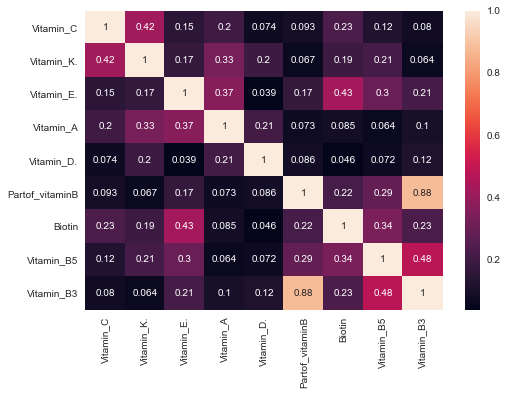

In [22]:
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','Vitamin_A','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5', 'Vitamin_B3']
vitaminS = products.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
sns.heatmap(corrvl, annot=True)

There isn't a particulater high correlation. There is a weak connection (0.25<x<0.5) between them all, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### checking correlations between all the things that contains sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

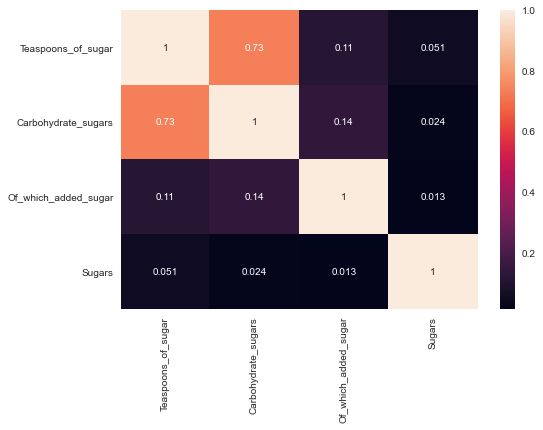

In [23]:
corr_matrix = products.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars'] #'From_sugars_to_organic_acids']
Sugars_matix = products.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph we can see that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Now, We'll check the correlation between Teaspoons_of_sugar, Carbohydrate_sugars and price_per_100g (in order to decide on which of the two columns we should give up), But before we'll decide to drop the Carbohydrate sugars (if it'll come to that) column we''ll check as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [24]:
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.4552399032913232


The correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [25]:
products = merge_two_columns('Carbohydrate_sugars', 'Teaspoons_of_sugar', products, 'Product_Name')

###### checking correlations between energy and the rest of the nutrition values:

In [26]:
corr_matrix = products.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False).head(10))

energy                    1.000000
Fats                      0.755486
Carbohydrates             0.434011
Carbohydrate_sugars       0.352774
Dietary_fiber             0.220607
iron                      0.142810
Proteins                  0.134315
Cholesterol               0.095170
Of_which_saturated_fat    0.085471
Trans_fatty_acids         0.073750
Name: energy, dtype: float64


The strong correlation between "energy" and "Fats" is high, beacuse as we found at wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 

In [27]:
column_1 = products["energy"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = products["Fats"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)
products = merge_two_columns('Fats', 'energy', products, 'Product_Name')#the correlation with Fats is higher. thus, we merged the energy column into the Fats column

correlation with energy  0.03591838259657959
correlation with Fats  0.08301273675673299


###### checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fat acid. In they're compound, Linoleic_fatty_acid has 2 more hydrogen than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

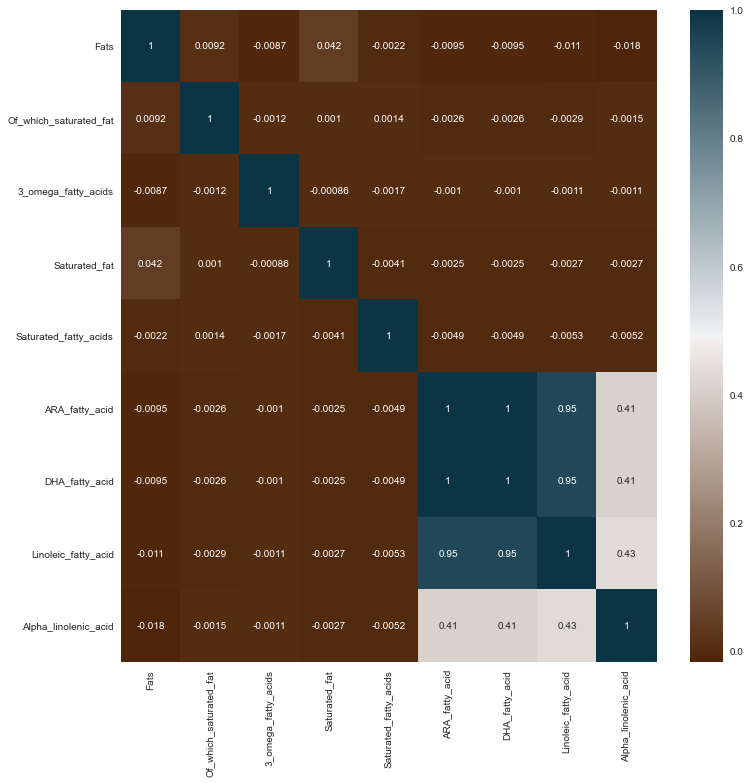

In [28]:
Ft = ['Fats','Of_which_saturated_fat','3_omega_fatty_acids','Saturated_fat','Saturated_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid'] #,'Polyunsaturated_fat'
Fats_list = products.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

we can see from graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further in the origins of ARA_fatty_acid. 

we found out that Linoleic acid, ARA_fatty_acid are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we descovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [29]:
products['6_omega_fatty_acids'] = products['ARA_fatty_acid']
products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'Product_Name')

<AxesSubplot:>

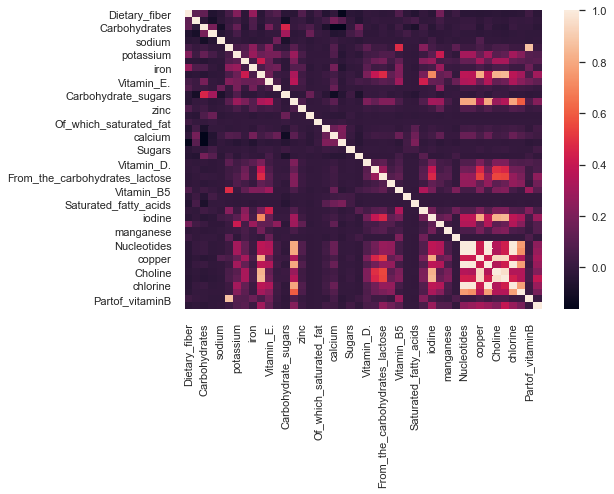

In [30]:
corr_matrix = products.corr()
sns.heatmap(corr_matrix) #in order to see if there's anything else worth checking

In [31]:
print(corr_matrix["Nucleotides"].sort_values(ascending=False).head(15))
#didn't found the connection between the features, but:
#found a connection between taurine on toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420
#found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/
#found a rate studies of destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/
products['have_to_do_with_milk'] = products['Nucleotides'] #found that Nucleotides, choline and taurine are all in babys' milk frmula
products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', products, 'Product_Name')
products = merge_two_columns('have_to_do_with_milk', 'Choline', products, 'Product_Name')
products = merge_two_columns('have_to_do_with_milk', 'Taurine', products, 'Product_Name')
#we have consulted with a chimist but the only big connection was between the molecular structure of Vitamin_A and 6_omega_fatty_acids, and the fact that they are both dissolved in fat / both fatty

Nucleotides                       1.000000
Taurine                           0.997687
selenium                          0.995871
chlorine                          0.995087
Vitamin_A                         0.796840
Carnitine                         0.762551
Inositol                          0.432191
copper                            0.420569
iodine                            0.380544
Vitamin_K.                        0.376473
Choline                           0.353620
phosphorus                        0.348150
Vitamin_E.                        0.345207
potassium                         0.309447
From_the_carbohydrates_lactose    0.275121
Name: Nucleotides, dtype: float64


In [32]:
#products2 = merge_two_columns('Carbohydrate_sugars', 'Teaspoons_of_sugar', products2, 'Product_Name')

## 4. Choosing a metric method and checking habits of dummy-model: 

After we accomplished all of our goals from the beginning and in that preapered the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measures. we decided to measure are project by RMSE.

RMSE means- is the square root of the mean of the square of all of the error.

we decided to choose RMSE because it is considered an excellent general-purpose error metric for numerical predictions.

what we'll do to a new data coming into the system (such as the test set):
(first set two, then set 1):
and then we checked the dummy regressor score

In [33]:
def data_ready_version_1(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_products = dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('sodium', 'chloride', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Folic_acid','Vitamin_B1','Vitamin_B12'], axis=1)
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    dataw_products['6_omega_fatty_acids'] = dataw_products['ARA_fatty_acid']
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    dataw_products['have_to_do_with_milk'] = dataw_products['Nucleotides'] #found that Nucleotides, choline and taurine are all in babys' milk frmula
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Choline', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [38]:
def data_ready_version_2(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    
    
    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    
    dataw_products = dataw.drop("price_per_100g", axis=1).iloc[:,2:26] 
    dataw_prices = dataw["price_per_100g"].copy()
    
    
    return dataw_products, dataw_prices

In [39]:
def RMSE(real, prediction):
    return np.sqrt(MSE(real, prediction))

In [40]:
test_set_prod1, test_set_prices1 = data_ready_version_1(test_set)

In [41]:
test_set_prod2, test_set_prices2 = data_ready_version_2(test_set)

In [42]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum1 = dummy_regr.predict(test_set_prod1)
mser = RMSE(test_set_prices1, predictdum1)
print( "Dummy Regressor mean squered error of " + str(mser)[:4])

Dummy Regressor mean squered error of 11.5


In [43]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products2, prices2)
predictdum2 = dummy_regr.predict(test_set_prod2)
mser = RMSE(test_set_prices2, predictdum2)
print( "Dummy Regressor mean squered error of " + str(mser)[:4])

Dummy Regressor mean squered error of 11.5


## 5. Sampling models (and checking with cross validation):

For each model we tried to find every parameter's importance by Feature Importance and by tried to fine-tuning our models: https://machinelearningmastery.com/calculate-feature-importance-with-python/

## A. Linear regression

In [44]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

lin_reg = LinearRegression()
predict1 = cross_val_predict(lin_reg, products, prices, cv=kf)
rmse_linreg1 = RMSE(prices, predict1)
print(rmse_linreg1)

lin_reg = LinearRegression()
predict2 = cross_val_predict(lin_reg, products2, prices2, cv=kf)
rmse_linreg2 = RMSE(prices2, predict2)
print(rmse_linreg2)

10.075920788455182
10.070340592491851


Feature: 0, Score: 0.05745
Feature: 1, Score: 0.00565
Feature: 2, Score: -0.03592
Feature: 3, Score: -0.00128
Feature: 4, Score: 0.00006
Feature: 5, Score: -0.11180
Feature: 6, Score: -0.00348
Feature: 7, Score: -0.04753
Feature: 8, Score: -0.05145
Feature: 9, Score: -0.16710
Feature: 10, Score: 0.88212
Feature: 11, Score: 0.00046
Feature: 12, Score: 0.05549
Feature: 13, Score: -0.00445
Feature: 14, Score: -0.01436
Feature: 15, Score: -0.05997
Feature: 16, Score: 0.00064
Feature: 17, Score: 0.01995
Feature: 18, Score: 0.00039
Feature: 19, Score: 0.00786
Feature: 20, Score: -0.10930
Feature: 21, Score: 0.15467
Feature: 22, Score: -0.02264
Feature: 23, Score: -0.24811
Feature: 24, Score: 0.07996
Feature: 25, Score: 0.00095
Feature: 26, Score: 0.50622
Feature: 27, Score: 0.14828
Feature: 28, Score: 0.01957
Feature: 29, Score: -0.20625
Feature: 30, Score: 0.08789
Feature: 31, Score: -0.00088
Feature: 32, Score: -0.01187
Feature: 33, Score: 0.01093
Feature: 34, Score: -0.55887
Feature: 35, 

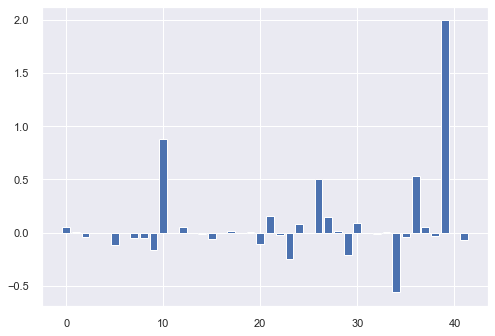

Feature: 10, Score: 0.88212
Feature: 26, Score: 0.50622
Feature: 34, Score: -0.55887
Feature: 36, Score: 0.53661
Feature: 39, Score: 1.99288


In [45]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products, prices)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.3:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [46]:
lin_reg = LinearRegression()
productsv = products.iloc[:,listm]
predict = cross_val_predict(lin_reg, productsv, prices, cv=kf)
rmse_linreg1_v2 = RMSE(prices, predict)
print(rmse_linreg1_v2)

10.113022027497829


Feature: 0, Score: 0.01531
Feature: 1, Score: 0.02548
Feature: 2, Score: -0.00368
Feature: 3, Score: 0.00168
Feature: 4, Score: -0.01072
Feature: 5, Score: 0.08510
Feature: 6, Score: 0.00005
Feature: 7, Score: -0.28730
Feature: 8, Score: -0.00233
Feature: 9, Score: -0.05152
Feature: 10, Score: -0.13983
Feature: 11, Score: -0.01143
Feature: 12, Score: 0.08196
Feature: 13, Score: 0.24091
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.02288
Feature: 16, Score: -0.00134
Feature: 17, Score: 0.17066
Feature: 18, Score: -0.00741
Feature: 19, Score: -0.05790
Feature: 20, Score: -0.00013
Feature: 21, Score: -0.03756
Feature: 22, Score: 0.06923
Feature: 23, Score: 0.00070


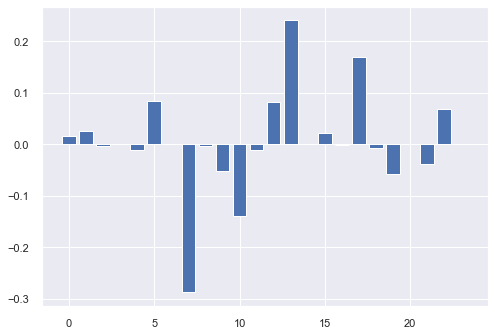

Feature: 0, Score: 0.01531
Feature: 1, Score: 0.02548
Feature: 2, Score: -0.00368
Feature: 3, Score: 0.00168
Feature: 4, Score: -0.01072
Feature: 5, Score: 0.08510
Feature: 6, Score: 0.00005
Feature: 7, Score: -0.28730
Feature: 8, Score: -0.00233
Feature: 9, Score: -0.05152
Feature: 10, Score: -0.13983
Feature: 11, Score: -0.01143
Feature: 12, Score: 0.08196
Feature: 13, Score: 0.24091
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.02288
Feature: 16, Score: -0.00134
Feature: 17, Score: 0.17066
Feature: 18, Score: -0.00741
Feature: 19, Score: -0.05790
Feature: 20, Score: -0.00013
Feature: 21, Score: -0.03756
Feature: 22, Score: 0.06923
Feature: 23, Score: 0.00070


In [47]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products2, prices2)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.0000001:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [48]:
lin_reg = LinearRegression()
productsv2 = products.iloc[:,listm]
predict2 = cross_val_predict(lin_reg, productsv2, prices2, cv=kf)
rmse_linreg2_v2 = RMSE(prices, predict2)
print(rmse_linreg2_v2)

10.023100050165336


it seems that linear regression is not a good model for this problem

## B. Desicion tree regressor

In [49]:
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products, prices, cv=kf)
treereg_score1 = RMSE(prices, predicttree1)
print(treereg_score1)

predicttree2 = cross_val_predict(tree_reg, products2, prices2, cv=kf)
treereg_score2 = RMSE(prices2, predicttree2)
print(treereg_score2)

9.497979186235336
10.57978605621724


Feature: 0, Score: 0.02108
Feature: 1, Score: 0.29882
Feature: 2, Score: 0.03700
Feature: 3, Score: 0.06107
Feature: 4, Score: 0.42011
Feature: 5, Score: 0.00006
Feature: 6, Score: 0.00029
Feature: 7, Score: 0.00003
Feature: 8, Score: 0.00125
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00302
Feature: 11, Score: 0.00002
Feature: 12, Score: 0.05581
Feature: 13, Score: 0.00005
Feature: 14, Score: 0.00028
Feature: 15, Score: 0.00125
Feature: 16, Score: 0.04713
Feature: 17, Score: 0.00215
Feature: 18, Score: 0.00254
Feature: 19, Score: 0.00646
Feature: 20, Score: 0.00030
Feature: 21, Score: 0.02972
Feature: 22, Score: 0.00003
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00035
Feature: 27, Score: 0.00012
Feature: 28, Score: 0.00009
Feature: 29, Score: 0.00018
Feature: 30, Score: 0.00010
Feature: 31, Score: 0.00025
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00284
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

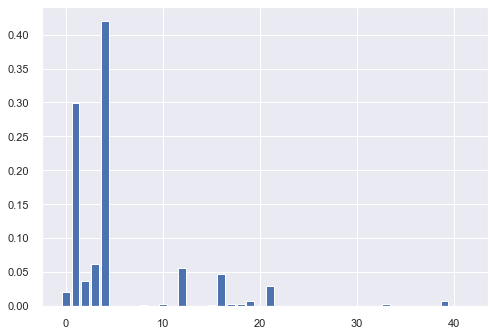

Feature: 0, Score: 0.02108
Feature: 1, Score: 0.29882
Feature: 2, Score: 0.03700
Feature: 3, Score: 0.06107
Feature: 4, Score: 0.42011
Feature: 12, Score: 0.05581
Feature: 16, Score: 0.04713
Feature: 19, Score: 0.00646
Feature: 21, Score: 0.02972
Feature: 39, Score: 0.00760


In [50]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products, prices)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi = []
for i,v in enumerate(importance):
    if v>0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi.append(i)

In [51]:
products_3 = products.iloc[:,listi]
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products_3, prices, cv=kf)
treereg_score1_v2 = RMSE(prices, predicttree1)
print(treereg_score1_v2)

9.4047909535942


Feature: 0, Score: 0.01757
Feature: 1, Score: 0.00239
Feature: 2, Score: 0.07870
Feature: 3, Score: 0.29731
Feature: 4, Score: 0.03775
Feature: 5, Score: 0.01915
Feature: 6, Score: 0.41523
Feature: 7, Score: 0.00011
Feature: 8, Score: 0.00008
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00313
Feature: 11, Score: 0.00783
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00084
Feature: 14, Score: 0.00069
Feature: 15, Score: 0.02469
Feature: 16, Score: 0.00131
Feature: 17, Score: 0.00005
Feature: 18, Score: 0.00028
Feature: 19, Score: 0.00132
Feature: 20, Score: 0.07251
Feature: 21, Score: 0.00140
Feature: 22, Score: 0.01449
Feature: 23, Score: 0.00315


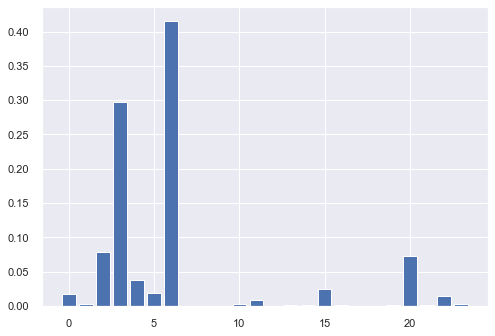

Feature: 0, Score: 0.01757
Feature: 1, Score: 0.00239
Feature: 2, Score: 0.07870
Feature: 3, Score: 0.29731
Feature: 4, Score: 0.03775
Feature: 5, Score: 0.01915
Feature: 6, Score: 0.41523
Feature: 10, Score: 0.00313
Feature: 11, Score: 0.00783
Feature: 15, Score: 0.02469
Feature: 16, Score: 0.00131
Feature: 19, Score: 0.00132
Feature: 20, Score: 0.07251
Feature: 21, Score: 0.00140
Feature: 22, Score: 0.01449
Feature: 23, Score: 0.00315


In [52]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products2, prices2)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi2 = []
for i,v in enumerate(importance):
    if v>0.001:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi2.append(i)

In [53]:
products2_3 = products.iloc[:,listi2]
tree_reg = DecisionTreeRegressor()

predicttree2 = cross_val_predict(tree_reg, products2_3, prices2, cv=kf)
treereg_score2_v2 = RMSE(prices2, predicttree2)
print(treereg_score2_v2)

10.812876471138647


## C. Random forest regressor

In [54]:
random_for = RandomForestRegressor()

prodicrfor1 = cross_val_predict(random_for, products, prices, cv=kf)
rmsefor1 = RMSE(prices, prodicrfor1)
print(rmsefor1)

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2, prices2, cv=kf)
rmsefor2 = RMSE(prices, prodicrfor2)
print(rmsefor2)

7.643678517725971
8.031242134244588


Feature: 0, Score: 0.03572
Feature: 1, Score: 0.08985
Feature: 2, Score: 0.07098
Feature: 3, Score: 0.11546
Feature: 4, Score: 0.42732
Feature: 5, Score: 0.00251
Feature: 6, Score: 0.00037
Feature: 7, Score: 0.00037
Feature: 8, Score: 0.00318
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00439
Feature: 11, Score: 0.00099
Feature: 12, Score: 0.11579
Feature: 13, Score: 0.00068
Feature: 14, Score: 0.00025
Feature: 15, Score: 0.00132
Feature: 16, Score: 0.07496
Feature: 17, Score: 0.00429
Feature: 18, Score: 0.00449
Feature: 19, Score: 0.01002
Feature: 20, Score: 0.00018
Feature: 21, Score: 0.02990
Feature: 22, Score: 0.00010
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00016
Feature: 25, Score: 0.00012
Feature: 26, Score: 0.00016
Feature: 27, Score: 0.00009
Feature: 28, Score: 0.00019
Feature: 29, Score: 0.00009
Feature: 30, Score: 0.00016
Feature: 31, Score: 0.00025
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00262
Feature: 34, Score: 0.00001
Feature: 35, Score: 0.00001
Fe

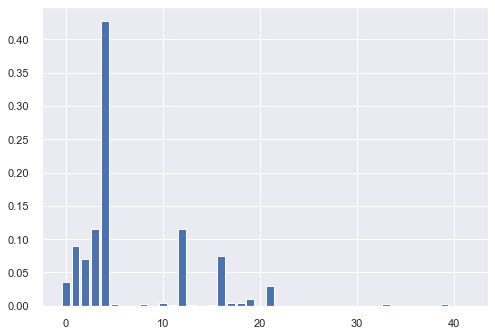

Feature: 0, Score: 0.03572
Feature: 1, Score: 0.08985
Feature: 2, Score: 0.07098
Feature: 3, Score: 0.11546
Feature: 4, Score: 0.42732
Feature: 12, Score: 0.11579
Feature: 16, Score: 0.07496
Feature: 19, Score: 0.01002
Feature: 21, Score: 0.02990


In [55]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products, prices)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
for i,v in enumerate(importance):
    if v>0.009:
        print('Feature: %0d, Score: %.5f' % (i,v))

In [56]:
v_2_1=[0,1,2,3,4,12,16,19,21]
products_2 = products.iloc[:,v_2_1]

random_for = RandomForestRegressor()
prodicrfor = cross_val_predict(random_for, products_2, prices, cv=kf)
rmsefor1_v2 = RMSE(prices, prodicrfor)
print(rmsefor1_v2)

7.673785626607876


Feature: 0, Score: 0.04358
Feature: 1, Score: 0.00506
Feature: 2, Score: 0.10139
Feature: 3, Score: 0.10929
Feature: 4, Score: 0.04162
Feature: 5, Score: 0.04037
Feature: 6, Score: 0.42953
Feature: 7, Score: 0.00020
Feature: 8, Score: 0.00036
Feature: 9, Score: 0.00036
Feature: 10, Score: 0.00350
Feature: 11, Score: 0.00644
Feature: 12, Score: 0.00002
Feature: 13, Score: 0.00078
Feature: 14, Score: 0.00106
Feature: 15, Score: 0.08937
Feature: 16, Score: 0.00078
Feature: 17, Score: 0.00064
Feature: 18, Score: 0.00018
Feature: 19, Score: 0.00124
Feature: 20, Score: 0.07855
Feature: 21, Score: 0.00206
Feature: 22, Score: 0.03944
Feature: 23, Score: 0.00418


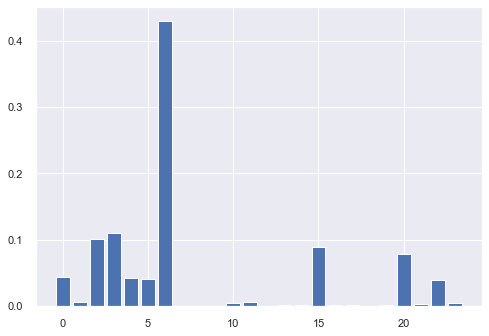

Feature: 0, Score: 0.04358
Feature: 2, Score: 0.10139
Feature: 3, Score: 0.10929
Feature: 4, Score: 0.04162
Feature: 5, Score: 0.04037
Feature: 6, Score: 0.42953
Feature: 15, Score: 0.08937
Feature: 20, Score: 0.07855
Feature: 22, Score: 0.03944


In [57]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products2, prices2)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
for i,v in enumerate(importance):
    if v>0.01:
        print('Feature: %0d, Score: %.5f' % (i,v))

In [58]:
v_2_2 = [0,2,3,4,5,6,15,19,20,22]
products2_2 = products.iloc[:,v_2_2]

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2_2, prices2, cv=kf)
rmsefor2_v2 = RMSE(prices2, prodicrfor2)
print(rmsefor2_v2)

8.03103085515618


## 6. Comparing models scores and choosing the final model:

In [59]:
print("Before Feature Importance, linear regression mean squered error is:")
print()
print("Data set 1: ", rmse_linreg1, ", Data set 2: ", rmse_linreg2)
print('\n')
print("After Feature Importance, linear regression mean squered error is:")
print()
print("Data set 1: ", rmse_linreg1_v2, ", Data set 2: ", rmse_linreg2_v2)

Before Feature Importance, linear regression mean squered error is:

Data set 1:  10.075920788455182 , Data set 2:  10.070340592491851


After Feature Importance, linear regression mean squered error is:

Data set 1:  10.113022027497829 , Data set 2:  10.023100050165336


In [60]:
print("Before Feature Importance, Desicion tree regressor mean squered error is:")
print()
print("Data set 1: ", treereg_score1, ", Data set 2: ", treereg_score2)
print('\n')
print("After Feature Importance, Desicion tree regressor mean squered error is:")
print()
print("Data set 1: ", treereg_score1_v2, ", Data set 2: ", treereg_score2_v2)

Before Feature Importance, Desicion tree regressor mean squered error is:

Data set 1:  9.497979186235336 , Data set 2:  10.57978605621724


After Feature Importance, Desicion tree regressor mean squered error is:

Data set 1:  9.4047909535942 , Data set 2:  10.812876471138647


In [61]:
print("Before Feature Importance, Random forest regressor mean squered error is:")
print()
print("Data set 1: ", rmsefor1, ", Data set 2: ", rmsefor2)
print('\n')
print("After Feature Importance, Random forest regressor mean squered error is:")
print()
print("Data set 1: ", rmsefor1_v2, ", Data set 2: ", rmsefor2_v2)

Before Feature Importance, Random forest regressor mean squered error is:

Data set 1:  7.643678517725971 , Data set 2:  8.031242134244588


After Feature Importance, Random forest regressor mean squered error is:

Data set 1:  7.673785626607876 , Data set 2:  8.03103085515618


In [62]:
print("Dummy regressor mean squered error is:", str(mser)[:4])

Dummy regressor mean squered error is: 11.5


From the comperation above we can conclude that our best model is Random Forest regressor with the second version of data set number 1 (each time we ran the project, the difference between the mistakes of version 1 and 2 of the first data set were close to each other, although every time another one of the was with a bigger mistake, due to the nature of the model).
Because the errors are close to each other, we will prefer the version of the model with the less features.

In [69]:
def final_data_preperation(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_products= dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    dataw_products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('sodium', 'chloride', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Folic_acid','Vitamin_B1','Vitamin_B12'], axis=1)
    dataw_products = merge_two_columns('Teaspoons_of_sugar', 'Carbohydrate_sugars', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Fats', 'energy', dataw_products, 'Product_Name')
    dataw_products['6_omega_fatty_acids'] = dataw_products['ARA_fatty_acid']
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    dataw_products['have_to_do_with_milk'] = dataw_products['Nucleotides'] #found that Nucleotides, choline and taurine are all in babys' milk frmula
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Nucleotides', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Choline', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw_products, 'Product_Name')
    
    v_2_1=[0,1,2,3,4,12,16,19,22]
    dataw_products = dataw_products.iloc[:,v_2_1]
    
    return dataw_products, dataw_prices

In [70]:
final_test_prod, final_test_price = final_data_preperation(test_set)

In [72]:
random_for = RandomForestRegressor()
random_for.fit(products_2, prices)
final_predict = random_for.predict(final_test_prod)
Rmse = RMSE(final_test_price, final_predict)
print( "Mean squered error of final model is: " + str(Rmse)[:4])

Mean squered error of final model is: 10.7


## 7. conclusion:

This type of project is too complicated to the models we know